In [1]:
import pandas as pd
import numpy as np
import glob
from svv_read import Sub_SVV
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sns.set_style("whitegrid")
sns.set(font="monospace", font_scale=1.5)
plt.rcParams['figure.figsize'] = 15,15
# pd.options.display.max_rows = 10

In [3]:
# create data frame for results3
df = pd.DataFrame()

readfolder = '../DATA/EXP2/'
list_subject = glob.glob(readfolder+'/S*')
# list_subject

## check following outliers

 - check S50: -20º values (bucket moved during test)
 - check S45: very high angle and very short RT
 - check S46: similar S45
 - check S47: low angles

In [4]:
for sub in list_subject:
    SUB = Sub_SVV(sub)
    df = df.append(SUB.create_table(), ignore_index=True)


In [5]:
# snb.stripplot(x='freq', y='SVV', data = df)
# snb.stripplot(x='freq', y='SVV', data = df[(df['stim']=='SH') & (df['SVV']>2.5)])

## check for Subjective Visual Vesrtical over 2.5º in control condition


In [6]:
outliers = [(np.abs(df.loc[i,'SVV'])>2.5) and (df.loc[i,'stim']=='CTRL') for i in df.index]
bad_id = df[outliers].id.unique()
df.insert(len(df.columns), 'Outliers', df['id'].isin(bad_id))
df['Reaction_time'] = df['Reaction_time']/1000 # adjustment time in sec

## graphical representation of SVV data with outliers in red

In [7]:
df.query('stim != "MX"').head()

,id,trial,stim,freq,rep,Angle_init,SVV,Reaction_time,Outliers
0,S67,T01,MF,120,T1,-21.060645,-0.527312,5.030,False
1,S67,T18,AC,60,T0,-20.586103,-0.519436,3.316,False
2,S67,T12,DC,0,T1,-24.734157,-2.567490,4.143,False
3,S67,T09,AC,160,T1,-21.389072,-0.389072,4.357,False
4,S67,T20,MF,20,T1,-22.588575,-1.121908,6.114,False


In [8]:
df.stim.unique()

array(['MF', 'AC', 'DC', 'MX', 'CTRL'], dtype=object)

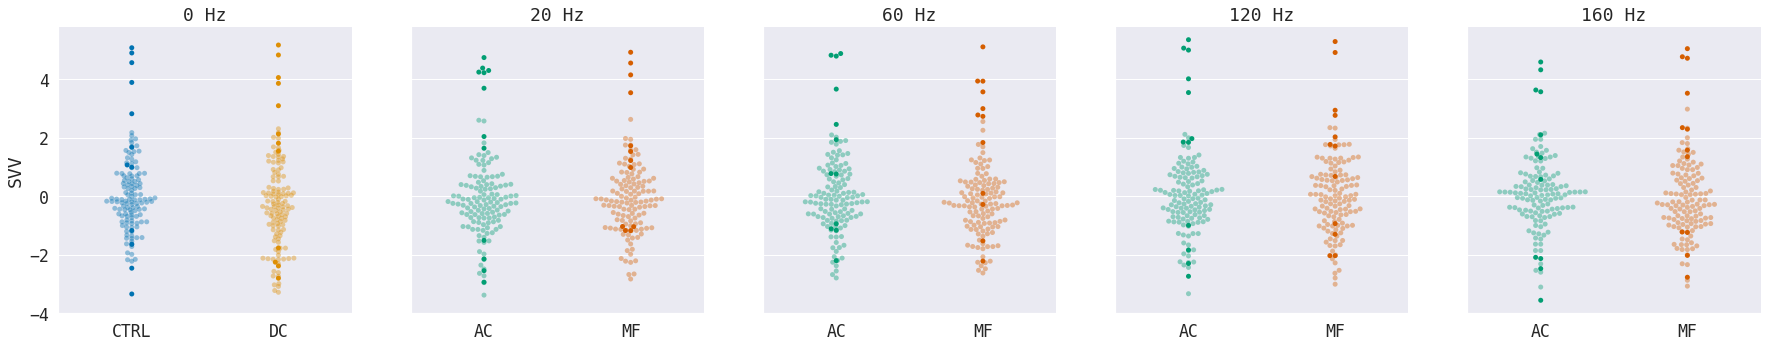

In [9]:
bool_good_id = ~df['id'].isin(bad_id)
bool_SHDC = df['freq'] == 0  # select CTRL and DC stimulation


if True:
    gdata = df.query('stim != "MX"')
    order = ['CTRL', 'DC', 'AC', 'MF']
    
    colorblind = sns.palettes.color_palette(palette='colorblind', n_colors=4)
    pal = dict(
        CTRL=colorblind[0], 
        DC=colorblind[1], 
        AC=colorblind[2],
        MF=colorblind[3]
    )
    
    g = sns.FacetGrid(gdata, 
                      col='freq', 
                      hue='Outliers',
                      hue_kws=dict(alpha=[0.4,1]),
                      sharex=False,
#                       aspect=0.8,
                      height=5
                     )  # check sns.catplot
                      
#     g.map(sns.swarmplot, 'stim', 'SVV', palette=pal, order=order, size=5, linewidth=1)
    
    for (i,j,k), data in g.facet_data():
        sorted_data = data.sort_values(by='stim')
        ax = g.facet_axis(i,j)
        s_pal = dict((k, v) for k, v in pal.items() if k in sorted_data.stim.unique())
        
        sns.swarmplot(data=sorted_data,
                     x='stim',
                     y='SVV',
                     hue='stim',
                     palette=s_pal,
                     alpha=g.hue_kws['alpha'][k]
                     )
        
        if j!=0:
            ax.set_ylabel('')
        
        ax.legend_.remove()
    
    g.set_titles("{col_name} Hz")
    g.set_xlabels('')
    

# Analysis over "good participants"

## Explore SVV variability:
In order to discuss potential effect of frequency of an alternating stimulation on SVV we decided to explore what could be the effect on the stability of the SVV adjustement over different exposure.

In [10]:
df.query('(id == "S53") & (stim == "DC")')

,id,trial,stim,freq,rep,Angle_init,SVV,Reaction_time,Outliers
975,S53,T22,DC,0,T0,-20.021244,-2.987910,3.824,False
984,S53,T04,DC,0,T0,-23.518912,-1.818912,7.182,False
1003,S53,T22,DC,0,T1,-24.030459,-3.030459,3.652,False
1008,S53,T04,DC,0,T1,-19.857591,-1.890924,10.740,False


In [11]:
ndf = df[bool_good_id]  # remove subject with outliers SHAM data
# ndf.insert(len(ndf.columns),'RT_deg',ndf['Reaction_time']/ndf['Angle_init'])  # create Time/deg column
ndf.insert(len(ndf.columns),'Adj_vel',(ndf['SVV']-ndf['Angle_init'])/ndf['Reaction_time'])  # create deg/time  (deg.s-1) column
ndf = ndf.drop(columns=['Angle_init','Reaction_time','Outliers'])

ndf_agg = ndf.groupby(['id','stim','freq']).agg(['mean', 'std']) # compute mean and std

ref_svv = ndf_agg.query('stim == "CTRL"')
ref_svv

SVV             Adj_vel          
                   mean       std      mean       std
id  stim freq                                        
S40 CTRL 0    -0.133333  0.679324  4.968270  1.293052
S41 CTRL 0     0.154135  0.243257  4.456588  1.108008
S42 CTRL 0    -0.352208  0.578948  3.082618  0.904358
S43 CTRL 0    -0.125796  0.677252  4.132866  0.710515
S44 CTRL 0    -0.527896  1.049951  4.842697  1.008108
S48 CTRL 0    -0.022167  0.578688  5.542574  0.544836
S49 CTRL 0    -1.798269  0.382961  3.712714  0.205739
S50 CTRL 0     0.253642  0.217998  2.988053  0.664856
S51 CTRL 0    -0.555378  0.414193  3.076436  1.334482
S52 CTRL 0     0.382002  1.490426  4.564312  1.077616
S53 CTRL 0    -1.681689  0.439831  1.609250  0.277977
S54 CTRL 0     1.268620  0.924760  6.648509  1.179605
S55 CTRL 0    -0.294813  0.297003  3.638940  0.664078
S56 CTRL 0     0.763077  0.984810  2.439759  0.643918
S57 CTRL 0     0.225377  0.592006  4.331547  0.045832
S58 CTRL 0     0.865960  1.288389  4.546888  1.401008
S59 CTRL 0     0.429083  0.753770  4.758655  1.050271
S60 CTRL 0     1.470021  0.659475  3.115618  0.821321
S61 CTRL 0     1.138504  0.417715  2.438509  0.780134
S62 CTRL 0    -0.003627  0.460234  2.367433  0.728915
S63 CTRL 0    -0.440768  0.316877  3.652728  1.158963
S64 CTRL 0     0.052419  0.493794  3.901772  0.362955
S65 CTRL 0     1.028438  0.259659  4.742364  1.214404
S66 CTRL 0    -0.618303  0.727939  4.851431  1.340233
S67 CTRL 0    -0.560398  0.131709  5.534776  1.214725
S68 CTRL 0    -0.663784  0.143318  5.916844  0.979009
S69 CTRL 0    -1.179175  0.511735  1.899576  0.620147
S70 CTRL 0    -0.779787  0.647332  4.304674  1.193266
S71 CTRL 0    -1.151723  0.814615  3.356466  0.452009
S72 CTRL 0     0.250464  0.503204  3.773277  0.729853

## create new table with delta-SVV as difference SVVcond - SVVctrl

In [12]:
to_subtract = ref_svv.reset_index(level=[1,2], drop=True)
to_subtract

SVV             Adj_vel          
         mean       std      mean       std
id                                         
S40 -0.133333  0.679324  4.968270  1.293052
S41  0.154135  0.243257  4.456588  1.108008
S42 -0.352208  0.578948  3.082618  0.904358
S43 -0.125796  0.677252  4.132866  0.710515
S44 -0.527896  1.049951  4.842697  1.008108
S48 -0.022167  0.578688  5.542574  0.544836
S49 -1.798269  0.382961  3.712714  0.205739
S50  0.253642  0.217998  2.988053  0.664856
S51 -0.555378  0.414193  3.076436  1.334482
S52  0.382002  1.490426  4.564312  1.077616
S53 -1.681689  0.439831  1.609250  0.277977
S54  1.268620  0.924760  6.648509  1.179605
S55 -0.294813  0.297003  3.638940  0.664078
S56  0.763077  0.984810  2.439759  0.643918
S57  0.225377  0.592006  4.331547  0.045832
S58  0.865960  1.288389  4.546888  1.401008
S59  0.429083  0.753770  4.758655  1.050271
S60  1.470021  0.659475  3.115618  0.821321
S61  1.138504  0.417715  2.438509  0.780134
S62 -0.003627  0.460234  2.367433  0.728915
S63 -0.440768  0.316877  3.652728  1.158963
S64  0.052419  0.493794  3.901772  0.362955
S65  1.028438  0.259659  4.742364  1.214404
S66 -0.618303  0.727939  4.851431  1.340233
S67 -0.560398  0.131709  5.534776  1.214725
S68 -0.663784  0.143318  5.916844  0.979009
S69 -1.179175  0.511735  1.899576  0.620147
S70 -0.779787  0.647332  4.304674  1.193266
S71 -1.151723  0.814615  3.356466  0.452009
S72  0.250464  0.503204  3.773277  0.729853

In [13]:
delta_svv = ndf_agg.sub(to_subtract,axis=0, level=0)
delta_svv = delta_svv.rename(columns = {'SVV':'dSVV', 'Adj_vel':'dVel'})
delta_svv.columns = ['_'.join(col) for col in delta_svv.columns]
delta_svv.reset_index(level=['stim', 'freq'], inplace=True)
delta_svv.head()

,stim,freq,dSVV_mean,dSVV_std,dVel_mean,dVel_std
id,,,,,,
S40,AC,20,-0.675000,-0.228502,-0.616033,-0.954626
S40,AC,60,-0.033333,-0.459897,0.564642,-0.628390
S40,AC,120,-0.050000,-0.094010,-0.074646,-0.490165
S40,AC,160,-0.108333,-0.059064,-0.317505,-0.688532
S40,CTRL,0,0.000000,0.000000,0.000000,0.000000


___
## __Graphics__

In [14]:
%matplotlib auto

data = delta_svv.query('freq != 0 & stim != "MX"')
data.freq.astype(int)

Using matplotlib backend: MacOSX


id
S40     20
S40     60
S40    120
S40    160
S40     20
      ... 
S72    160
S72     20
S72     60
S72    120
S72    160
Name: freq, Length: 240, dtype: int64

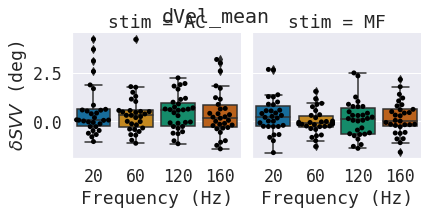

In [15]:
var = 'dVel_mean'

g = sns.FacetGrid(data, col='stim')  # check sns.catplot
g.map(sns.boxplot, 'freq', var, palette='colorblind', order=[20, 60, 120, 160])
g.map(sns.swarmplot, 'freq', var, color='black', order=[20, 60, 120, 160])
g.set_xlabels('Frequency (Hz)')
g.set_ylabels(r'$\delta SVV$ (deg)')

fig = plt.gcf()
fig.suptitle(f"{var}", fontsize=20)

if False:
    h = sns.FacetGrid(data, col='stim')
    h.map(sns.boxplot, 'freq', 'RT_deg_mean', palette='colorblind')
    h.map(sns.swarmplot, 'freq', 'RT_deg_mean', color='black')

# sns.boxplot(x='freq', y='SVV', data=data, hue='stim', palette='colorblind')
# sns.swarmplot(x='freq', y='SVV', data=data, hue='stim')

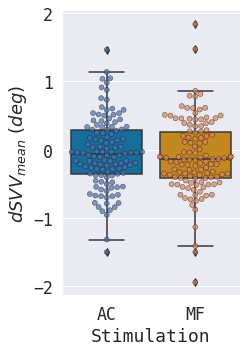

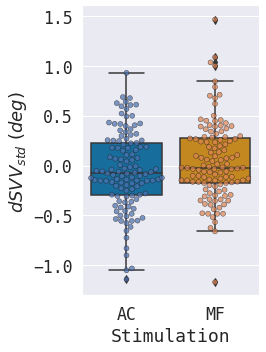

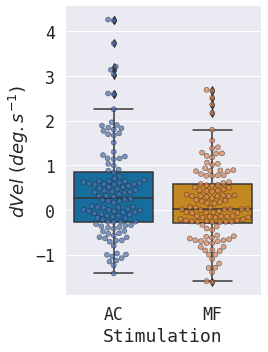

In [16]:
var = ['dSVV_mean', 'dSVV_std', 'dVel_mean']
ylabel = [
    r'$dSVV_{mean}\ (deg)$',
    r'$dSVV_{std}\ (deg)$',
    r'$dVel\ (deg.s^{-1})$'
]


for name, lab in zip(var,ylabel):
    k = sns.catplot(data=data,
                    kind='box',
                    x='stim',
                    y=name,
                    palette='colorblind',
#                     inner = 'box',
                    height=5,
                    aspect=3/4,
                   )
    sns.swarmplot(
        data=data,
        x='stim',
        y=name,
        alpha=0.7,
        size=5,
        edgecolor='k',
        linewidth=0.5
    )

    k.set_xlabels('Stimulation')
    k.set_ylabels(lab)

In [17]:
data.groupby(by=['stim'])[['dSVV_mean', 'dSVV_std', 'dVel_mean']].mean()

,dSVV_mean,dSVV_std,dVel_mean
stim,,,
AC,-0.049353,-0.055302,0.454816
MF,-0.101900,0.043322,0.149961


## Export data for [Statistical Analysis](./StatsR_deltaSVV.ipynb) with R

In [18]:
data.to_csv('TableRes_delta.csv')

In [19]:
fig = plt.figure(3)
fig.savefig('dVel.png', dpi=300)

<Figure size 432x288 with 0 Axes>

In [20]:
data.head(20)

,stim,freq,dSVV_mean,dSVV_std,dVel_mean,dVel_std
id,,,,,,
S40,AC,20,-0.675000,-0.228502,-0.616033,-0.954626
S40,AC,60,-0.033333,-0.459897,0.564642,-0.628390
S40,AC,120,-0.050000,-0.094010,-0.074646,-0.490165
S40,AC,160,-0.108333,-0.059064,-0.317505,-0.688532
S40,MF,20,0.441667,-0.148514,0.541942,-0.351864
S40,MF,60,-0.116667,-0.309640,-0.260552,-1.000860
S40,MF,120,-0.150000,-0.148427,0.055007,-0.858915
S40,MF,160,0.608333,0.294928,-0.149509,-0.328890
S41,AC,20,1.046989,0.352717,0.068820,-0.076877


___

# Explore Veloctity for potential outliers

In [21]:
data

,stim,freq,dSVV_mean,dSVV_std,dVel_mean,dVel_std
id,,,,,,
S40,AC,20,-0.675000,-0.228502,-0.616033,-0.954626
S40,AC,60,-0.033333,-0.459897,0.564642,-0.628390
S40,AC,120,-0.050000,-0.094010,-0.074646,-0.490165
S40,AC,160,-0.108333,-0.059064,-0.317505,-0.688532
S40,MF,20,0.441667,-0.148514,0.541942,-0.351864
...,...,...,...,...,...,...
S72,AC,160,-0.225638,-0.358395,-0.386081,-0.519966
S72,MF,20,-0.145716,-0.422441,-0.268376,0.648988
S72,MF,60,-0.177723,-0.130200,-0.273426,-0.412064


In [ ]:
test = ndf.reset_index(level=[1,2])
test.columns = ['_'.join(col) for col in test.columns]
test = test.query('stim_ != "MX"')
test[:20]

In [ ]:
%matplotlib inline
sns.boxplot(data=test, x='stim_', y='Adj_vel_mean')

In [ ]:
test.query('Adj_vel_mean < -7')

In [ ]:
%matplotlib inline

In [ ]:
delta_svv.stim.unique()

___
## __STATS DC vs CTRL__
test the positive control GVS effect on SVV

In [23]:
from scipy.stats import ttest_rel

In [26]:
res_tSVV = ttest_rel(
    ndf.query('stim == "CTRL"')['SVV'], 
    ndf.query('stim == "DC"')['SVV']
)

dff = len(ndf.query('stim == "CTRL"'))-1
r = np.sqrt((res_tSVV.statistic**2)/(dff+(res_tSVV.statistic**2)))
print(f't({dff}) = {res_tSVV.statistic:0.3}; p = {res_tSVV.pvalue:0.2}; r^2 = {r**2:0.2}')


t(119) = 3.08; p = 0.0026; r^2 = 0.074


In [27]:
res_tAVel = ttest_rel(
    ndf.query('stim == "CTRL"')['Adj_vel'], 
    ndf.query('stim == "DC"')['Adj_vel']
)

dff = len(df[bool_good_id].query('stim == "CTRL"'))-1
r = np.sqrt((res_tAVel.statistic**2)/(dff+(res_tAVel.statistic**2)))
print(f't({dff}) = {res_tAVel.statistic:0.3}; p = {res_tAVel.pvalue:0.2}, r_2 = {r**2:0.2}')

t(119) = -2.19; p = 0.031, r_2 = 0.039


In [46]:
plt.rcParams['figure.figsize'] = [13,10]
alpha = 0.7

f, ax = plt.subplots(nrows=1, ncols=2)
sns.boxplot(data=ndf.query('stim in ["CTRL", "DC"]'), x='stim', y='SVV', ax=ax[0], order=['CTRL', 'DC'])
sns.swarmplot(
    data=ndf.query('stim in ["CTRL", "DC"]'), 
    x='stim', 
    y='SVV', 
    ax=ax[0], 
    order=['CTRL', 'DC'],
    edgecolor='black',
    linewidth=1,
    alpha=alpha
)

sns.boxplot(data=ndf.query('stim in ["CTRL", "DC"]'), x='stim', y='Adj_vel', ax=ax[1], order=['CTRL', 'DC'])
sns.swarmplot(
    data=ndf.query('stim in ["CTRL", "DC"]'), 
    x='stim', y='Adj_vel', 
    ax=ax[1], 
    order=['CTRL', 'DC'],
    edgecolor='black',
    linewidth=1,
    alpha=alpha
)

<AxesSubplot:xlabel='stim', ylabel='Adj_vel'>

## __test dSVV for DC__
1. find deta SVV for DC in ```delta_svv``` data frame
2. test for normality with ```shapiro```
3. test difference to 0 mean normal distribution with ```ttest_1samp```

In [17]:
from scipy.stats import shapiro, ttest_1samp, probplot

In [18]:
delta_svv.head()

,stim,freq,dSVV_mean,dSVV_std,dVel_mean,dVel_std
id,,,,,,
S40,AC,20,-0.675000,-0.228502,-0.616033,-0.954626
S40,AC,60,-0.033333,-0.459897,0.564642,-0.628390
S40,AC,120,-0.050000,-0.094010,-0.074646,-0.490165
S40,AC,160,-0.108333,-0.059064,-0.317505,-0.688532
S40,CTRL,0,0.000000,0.000000,0.000000,0.000000


In [212]:
var = ['dSVV_mean', 'dSVV_std', 'dVel_mean']

for varname in var:
    SH_WILK = shapiro(delta_svv.query('stim == "DC"')[varname])
    res_ttest = ttest_1samp(delta_svv.query('stim == "DC"')[varname], 0)

    print(f'normality test for {varname} - p = {SH_WILK[1]:.3}')
    print(f'one-tailed t-test for {varname} - p = {res_ttest.pvalue/2:.3} \n')

normality test for dSVV_mean - p = 0.331
one-tailed t-test for dSVV_mean - p = 0.0269 

normality test for dSVV_std - p = 0.28
one-tailed t-test for dSVV_std - p = 0.45 

normality test for dVel_mean - p = 0.0819
one-tailed t-test for dVel_mean - p = 0.0473 



In [166]:
res_ttest.pvalue

Ttest_1sampResult(statistic=-2.0104291383846506, pvalue=0.05376714312096693)

In [169]:
delta_svv.query('stim == "DC"').mean()

freq         0.000000
dSVV_mean   -0.318981
dSVV_std    -0.010362
dVel_mean    0.340166
dVel_std     0.141056
dtype: float64

QQplot for normality

In [171]:
probplot(delta_svv.query('stim == "DC"')['dSVV_mean'], dist='norm', plot=plt)

((array([-1.99833768, -1.59452553, -1.35103668, -1.1686393 , -1.01855497,
         -0.8884856 , -0.77194854, -0.66506298, -0.56529149, -0.47085985,
         -0.38045711, -0.29306636, -0.20786198, -0.12414301, -0.04128669,
          0.04128669,  0.12414301,  0.20786198,  0.29306636,  0.38045711,
          0.47085985,  0.56529149,  0.66506298,  0.77194854,  0.8884856 ,
          1.01855497,  1.1686393 ,  1.35103668,  1.59452553,  1.99833768]),
  array([-1.74770179, -1.51100583, -1.43955669, -1.1977191 , -1.11585641,
         -1.10674033, -1.0959679 , -1.07824969, -0.95710116, -0.94961843,
         -0.75036226, -0.57734309, -0.50144817, -0.50072471, -0.44474043,
         -0.40668001, -0.18875076, -0.1508774 , -0.09166667,  0.02405857,
          0.0926457 ,  0.15234013,  0.1609416 ,  0.21980878,  0.25809511,
          0.4594182 ,  0.65026536,  0.83468237,  1.2605253 ,  2.12990674])),
 (0.8836781439783585, -0.3189807660599016, 0.9784026611988521))

In [172]:
0.0537/2

0.02685

## Test normality d-data

In [19]:
data.head()

,stim,freq,dSVV_mean,dSVV_std,dVel_mean,dVel_std
id,,,,,,
S40,AC,20,-0.675000,-0.228502,-0.616033,-0.954626
S40,AC,60,-0.033333,-0.459897,0.564642,-0.628390
S40,AC,120,-0.050000,-0.094010,-0.074646,-0.490165
S40,AC,160,-0.108333,-0.059064,-0.317505,-0.688532
S40,MF,20,0.441667,-0.148514,0.541942,-0.351864


In [27]:
stim = ['AC', 'MF']
for stimname in stim:
    SW = shapiro(data.query('stim == @stimname')['dVel_mean'])
    print(f'Shapiri-Wilk for {stimname}: {SW[0]:.3} - p-value = {SW[1]:.3}')

Shapiri-Wilk for AC: 0.914 - p-value = 1.06e-06
Shapiri-Wilk for MF: 0.969 - p-value = 0.00671


In [29]:
ttest_1samp(data.query('stim == "AC"')['dVel_mean'], 0)

Ttest_1sampResult(statistic=4.478489793300829, pvalue=1.736286109635329e-05)

0.145